In [43]:
import pytesseract as pt
from PIL import Image
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [2]:
pt.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [44]:
# Make directories

if not os.path.exists('./tesseract'):
        os.mkdir('./tesseract')
if not os.path.exists('./results'):
    os.mkdir('./results')

In [3]:
def img_size(image):
    size = len(image) * len(image[0])
    return size

In [4]:
def get_gray_arr(image):
    grayscale_array = []
    for w in range(0,len(img[0])):
        for h in range(0,len(img)):
            #intensity = image.getpixel((h,w))
            intensity = image[h,w]
            grayscale_array.append(intensity)
    return grayscale_array

In [5]:
def get_hist(image):
    #grayscale_array = get_gray_arr(image)
    bins = range(0,257)
    img_histogram = np.histogram(image, bins)
    return img_histogram

# Global Thresholding with Otsu
---

In [45]:
def otsu(image, do_savefile):
    hist = get_hist(image)
    size = img_size(image)
    current_max, th = 0, 0
    sumT, sumF, sumB = 0, 0, 0
    for i in range(0,256):
        sumT += i * hist[0][i]
    weightB, weightF = 0, 0
    varBetween, meanB, meanF = 0, 0, 0
    for i in range(0,256):
        weightB += hist[0][i]
        weightF = size - weightB
        if weightF == 0:
            break
        sumB += i*hist[0][i]
        sumF = sumT - sumB
        meanB = sumB/weightB
        meanF = sumF/weightF
        varBetween = weightB * weightF
        varBetween *= (meanB-meanF)*(meanB-meanF)
        if varBetween > current_max:
            current_max = varBetween
            th = i 
    #print ("threshold is:", th)
    
    ret,thresh = cv.threshold(image,th,255,cv.THRESH_BINARY)
    if do_savefile:
        cv.imwrite(f'results/{file_name}_global.png',thresh)
    return thresh

2


<ipython-input-45-3978cdc0d43f>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  meanB = sumB/weightB


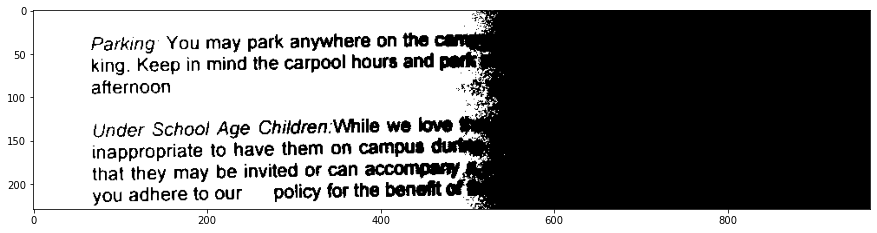

In [47]:
file_name = "sample01"
try:
    #img = Image.open(file_name)
    #img.load()
    #img.show()
    img = cv.imread(f'{file_name}.png',0)
    #bw = img.convert('L')
    #bw.show()
    print(img.ndim)
    if img.ndim > 2:
        img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
except IOError:
    print ("Unable to open file. Please try another format.")

thresh = otsu(img,True)
plt.figure(figsize=(15,10))
plt.imshow(thresh,'gray')

# Adaptive Thresholding with Otsu
---

In [8]:
def adaptive_thresh_otsu(image, num_row, num_col):
    processed_img = image
    print(len(image))
    print(len(image[0]))
    interval_height = int(np.ceil(len(image)/num_row))
    interval_width = int(np.ceil(len(image[0])/num_col))
    print(interval_height,interval_width)
    for col in range(num_col):
        for row in range(num_row):
            lower_bound_h = row * interval_height
            upper_bound_h = (row+1) * interval_height
            lower_bound_w = col * interval_width
            upper_bound_w = (col+1) * interval_width
            if upper_bound_h > len(image):
                upper_bound_h = len(image)
            if upper_bound_w > len(image[0]):
                upper_bound_w = len(image[0])
            img_snip = image[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w]
            if img_snip.size == 0:
                continue
            processed_img[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w] = otsu(img_snip, False)
    return processed_img

In [84]:
file_name = 'sample02'
image = cv.imread('sample02.png',0)
processed = adaptive_thresh_otsu(image, 40, 70)

782
589
20 9


<ipython-input-45-3978cdc0d43f>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  meanB = sumB/weightB


True

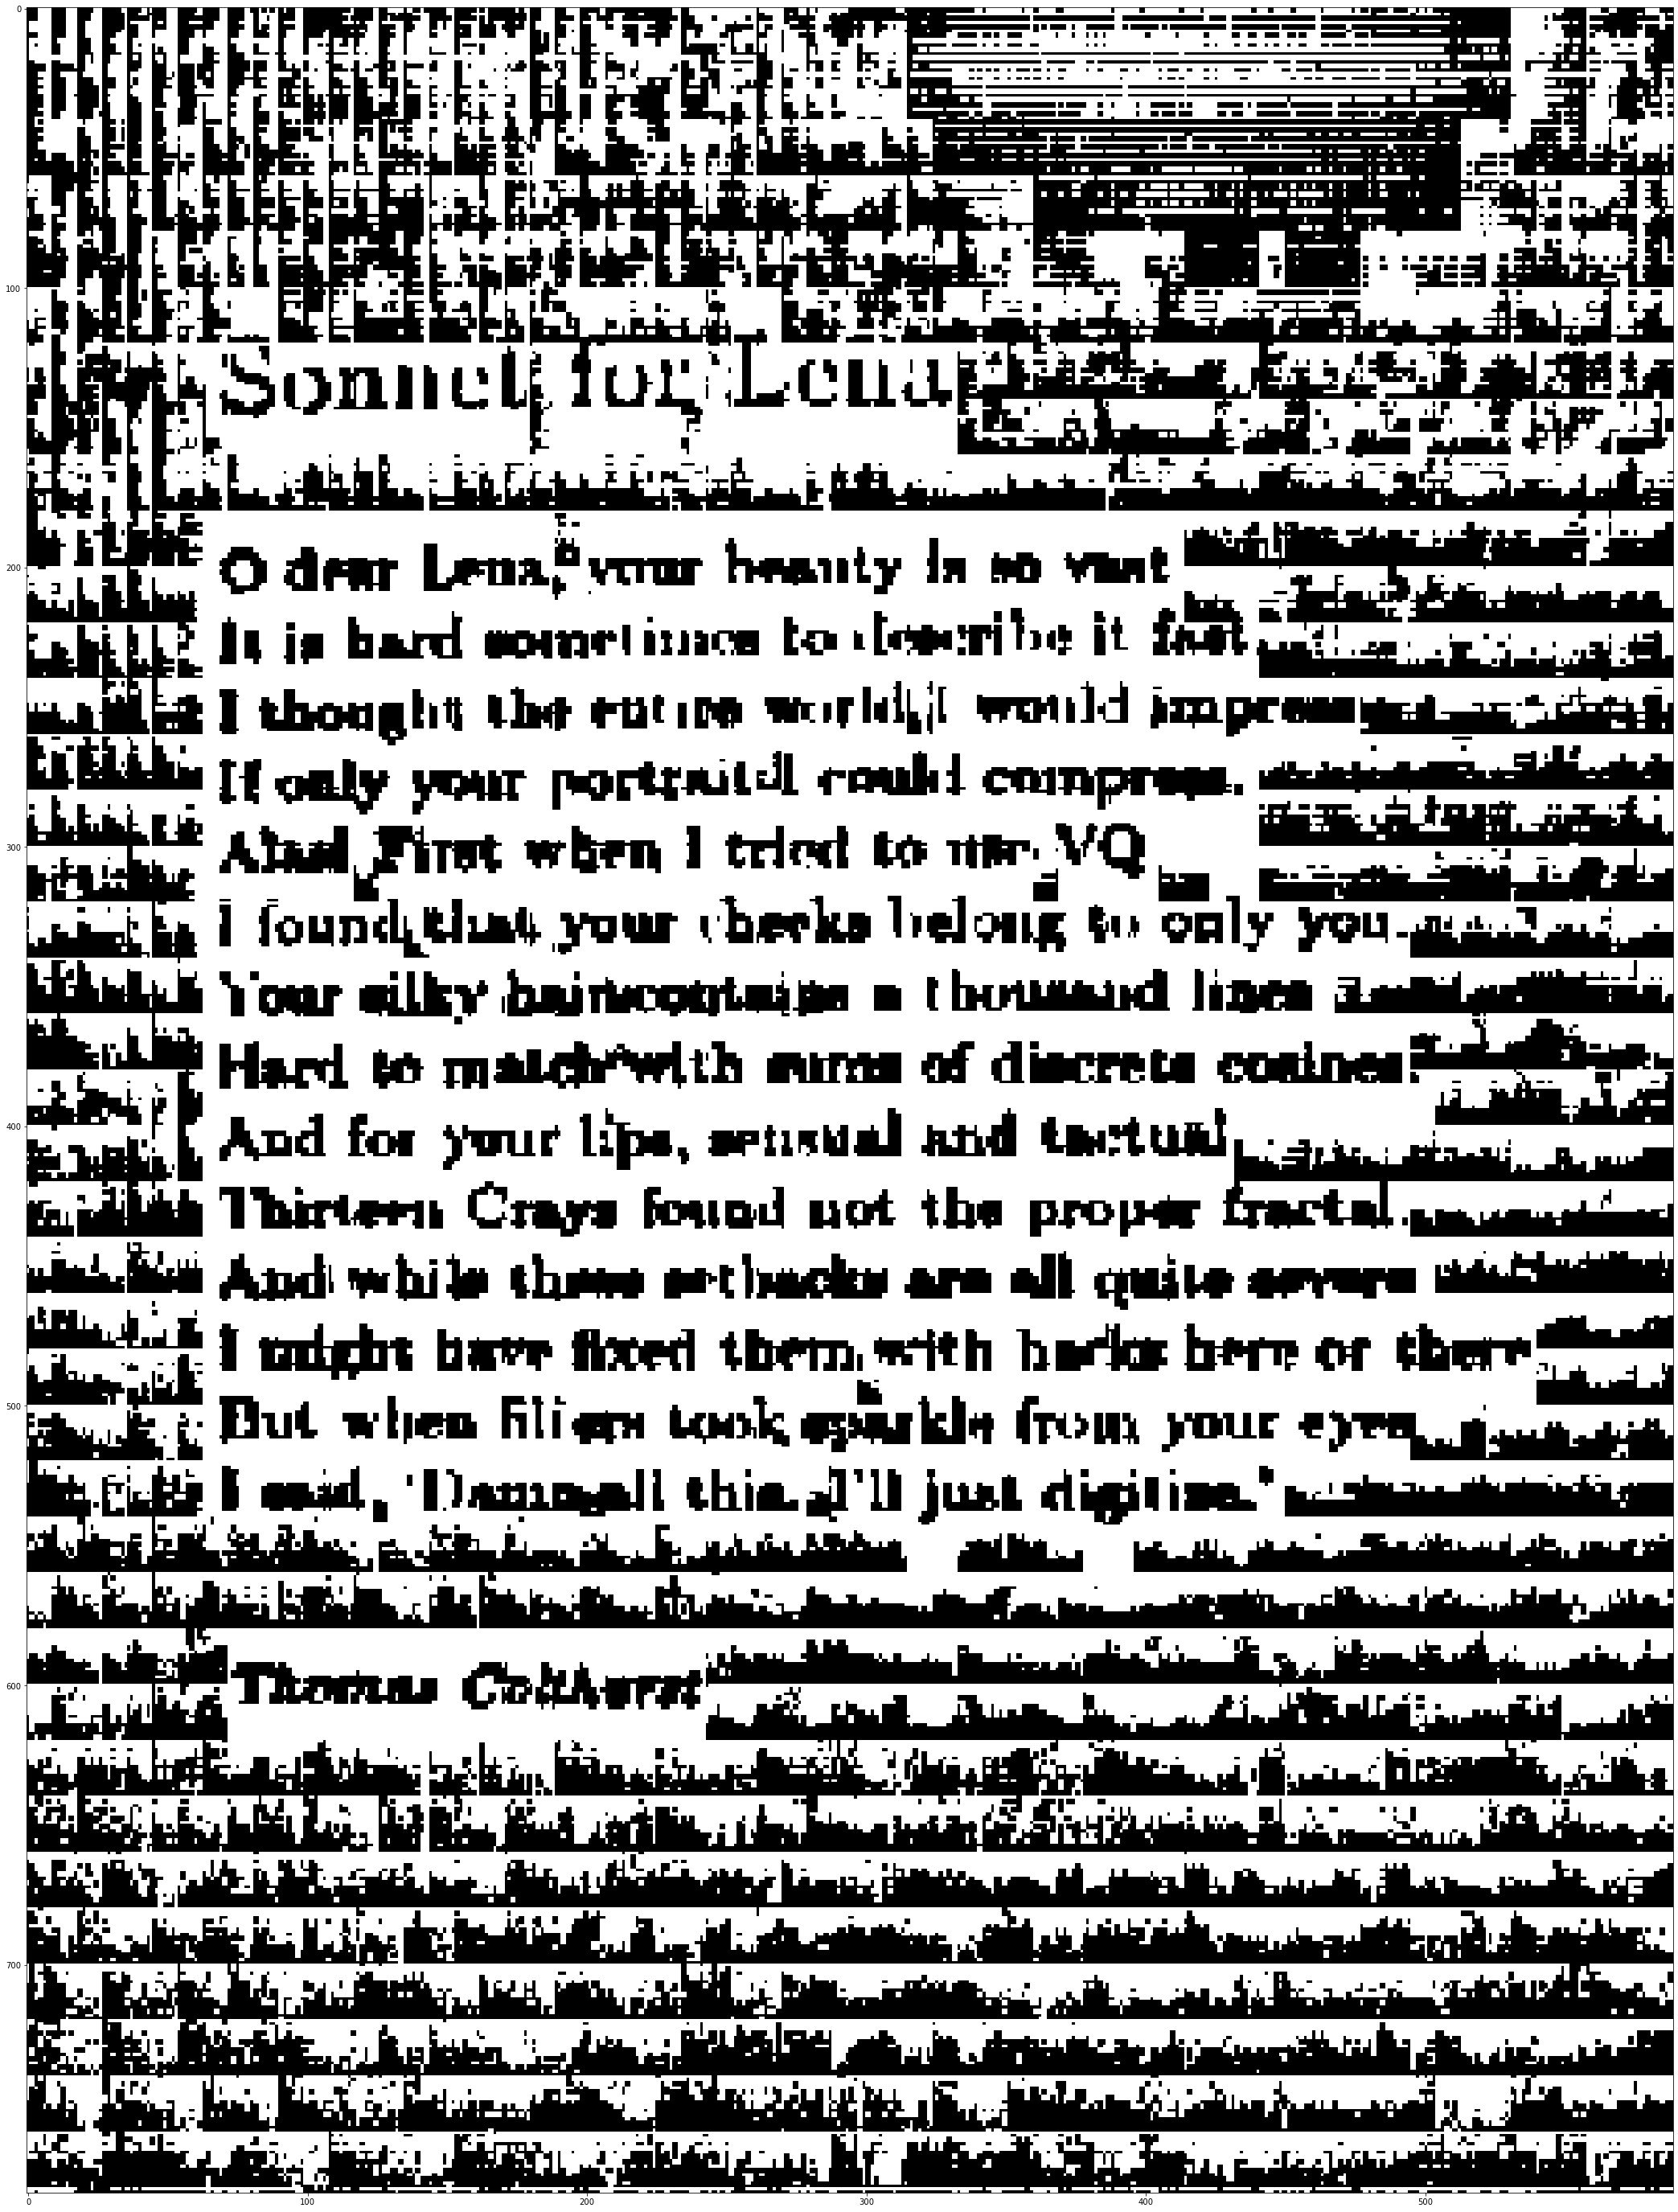

In [85]:
plt.figure(figsize=(50,50))
plt.imshow(processed,'gray')
cv.imwrite(f'results/{file_name}_adaptive.png',processed)

In [86]:
print(pt.image_to_string(processed))
with open(f"tesseract/{file_name}_adapt_output.txt", "w") as text_file:
    text_file.write(pt.image_to_string(processed))

 

© dear Lenafivenr heauty da oo vent a

2 iy ia bard sometinace to lescribe it 280.
21 thought whe ence world il would imprecise
BILLS Tf omty your portraitel raul compregs, wntomamaibicdhd
ae ret when 1 tried te wer VQ noone a
1 foundytiuas your vbecks belong to only you, i
‘Your silky baitweoninipa = thousand lines ieee
Hard bo malch“with mura of discreta cosines
ie) And for your Lips, setrsual aid tactuad nr
ete Thirteen Crays found not the proper il
piel Adi while thee ortincke ore all cuile eevere oo
ceetak V tight beer five themwith harks bere or there test
j But when Alien took sparkle from your er
Fesdd, ‘Daramall thia.al'll just cligit ime." usin
ga Sh bin

  



# Adaptive Thresholding with Mean
---

In [87]:
image = cv.imread('sample01.png',0)
print(image.size)

220985


In [127]:
def process_mean_area(image, int_h, int_w):
    
    curr_pixel = image[len(image)-int_h, len(image[0])-int_w]
    
    total = 0
    for height in range(len(image)):
        for width in range(len(image[0])):
            total += image[height,width]
    
    image_mean = total/img_size(image)
    
    if curr_pixel < image_mean - 10: #10 for sample 1, 5 for sample 2
        return 0
    else:
        return 255
            

In [108]:
# Box_height and box_width parameters must be odd
def adaptive_thresh_mean(image1, box_height, box_width):
    processed_img = image1.copy()
    print(len(image1))
    print(len(image1[0]))
    interval_height = int(np.floor(box_height/2))
    interval_width = int(np.floor(box_width/2))
    print(interval_height,interval_width)
    upper_edge = False
    
    for height in range(len(image1)):
        lower_bound_h = height - interval_height
        upper_bound_h = height + interval_height
        diff_h = 0
        
        if height < interval_height:
            lower_bound_h = 0
            upper_bound_h = height + (interval_height)
        elif height > (len(image1) - (interval_height + 1)):
            lower_bound_h = height - (interval_height)
            upper_bound_h = len(image1)
            diff_h = interval_height - (len(image1) - height)
            
            
        for width in range(len(image1[0])):
            diff_w = 0
            lower_bound_w = width - interval_width
            upper_bound_w = width + interval_width
            
            if width < interval_width:
                lower_bound_w = 0
                upper_bound_w = width + (interval_width)
            elif width > (len(image1[0]) - (interval_width + 1)):
                lower_bound_w = width - (interval_width)
                upper_bound_w = len(image1[0])
                diff_w = interval_width - (len(image1[0]) - width)
                
            img_snip = image1[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w]

            if img_snip.size == 0:
                continue
            processed_img[height, width] = process_mean_area(img_snip, (interval_height - diff_h), 
                                                             (interval_width - diff_w))
    return processed_img

229
965
8 8


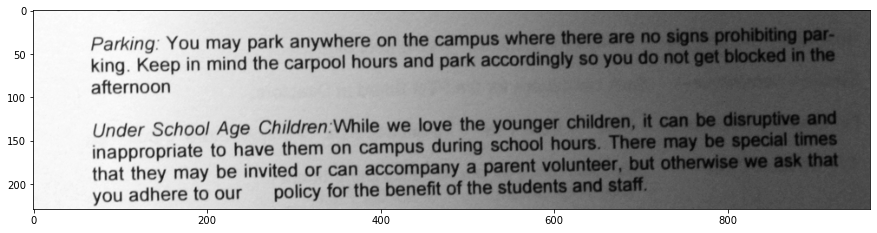

In [128]:
file_name = 'sample01'
image = cv.imread('sample01.png',0)
plt.figure(figsize = (15,15))
plt.imshow(image,'gray')

processed_mean = adaptive_thresh_mean(image, 17, 17)

True

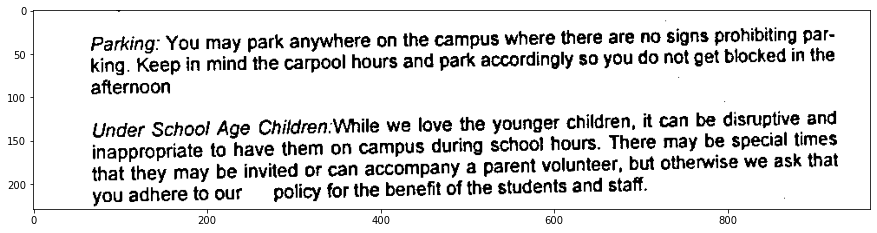

In [130]:
plt.figure(figsize = (15,15))
plt.imshow(processed_mean,'gray')
cv.imwrite(f'results/{file_name}_adaptive_mean_c.png',processed_mean)

In [131]:
print(pt.image_to_string(processed_mean))
with open(f"tesseract/{file_name}_adapt_mean_c_output.txt", "w") as text_file:
    text_file.write(pt.image_to_string(processed_mean))

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children.While we love the younger children, it can be disruptive and
inappropriate to have them on campus during schoo! hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our ~— policy for the benefit of the students and staff.

